# 06 - Skill Gap Analyzer Model

This notebook develops and evaluates the Skill Gap Analyzer that compares
user skills against job requirements using cosine similarity.

**Inputs:**
- `skill_taxonomy_categorized.parquet` — taxonomy with 5 categories (from notebook 05)
- `skill_embeddings.parquet` — 384-dim vectors
- `job_skill_mapping.parquet` — 285,659 job-skill pairs
- ChromaDB `skill_taxonomy` collection (from notebook 05)

**Outputs:**
- ChromaDB `job_titles` collection (populated)
- Validated `SkillGapAnalyzer` class in `ml/src/skill_gap_analyzer.py`

## 6.1 Setup & Load Data

In [1]:
import sys
sys.path.insert(0, str(__import__('pathlib').Path.cwd().parent.parent))

import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from collections import Counter
from sentence_transformers import SentenceTransformer
import chromadb
import warnings
warnings.filterwarnings('ignore')

PROCESS_DIR = Path('../data/process')

# Load processed data
df_taxonomy = pd.read_parquet(PROCESS_DIR / 'skill_taxonomy_categorized.parquet')
df_embeddings = pd.read_parquet(PROCESS_DIR / 'skill_embeddings.parquet')
df_job_skills = pd.read_parquet(PROCESS_DIR / 'job_skill_mapping.parquet')

print(f'Categorized Taxonomy: {len(df_taxonomy)} skills')
print(f'Category distribution:')
print(df_taxonomy['category'].value_counts())
print(f'\nJob-Skill Mapping: {len(df_job_skills):,} pairs')
print(f'Unique jobs: {df_job_skills["job_id"].nunique():,}')
print(f'Unique skills: {df_job_skills["skill"].nunique():,}')

/opt/homebrew/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Categorized Taxonomy: 1498 skills
Category distribution:
category
tech_skills          551
domain_knowledge     432
leadership           290
soft_skills          151
adaptation_skills     74
Name: count, dtype: int64

Job-Skill Mapping: 285,659 pairs
Unique jobs: 28,143
Unique skills: 1,483


## 6.2 Job Title Normalization & Skill Aggregation

In [2]:
from ml.src.chromadb_manager import _normalize_job_title, _aggregate_job_skills
from ml.src.config import NOISE_SKILLS

# Normalize titles
df_job_skills['title_normalized'] = df_job_skills['job_title'].apply(_normalize_job_title)

# Show distribution of jobs per normalized title
title_counts = df_job_skills.groupby('title_normalized')['job_id'].nunique().sort_values(ascending=False)
print(f'Total unique normalized titles: {len(title_counts)}')
print(f'Titles with >= 3 jobs: {(title_counts >= 3).sum()}')
print(f'\nTop 20 job titles by frequency:')
for title, count in title_counts.head(20).items():
    print(f'  {title:45s} {count:5d} jobs')

Total unique normalized titles: 9528
Titles with >= 3 jobs: 860

Top 20 job titles by frequency:
  quantum software developer                     1278 jobs
  smart contract engineer                        1255 jobs
  renewable energy engineer                      1254 jobs
  blockchain developer                           1245 jobs
  quantum researcher                             1241 jobs
  sustainability analyst                         1237 jobs
  ai engineer                                     877 jobs
  data scientist                                  855 jobs
  ml researcher                                   812 jobs
  project engineer                                379 jobs
  software engineer                               303 jobs
  process engineer                                177 jobs
  project manager                                 151 jobs
  it executive                                    147 jobs
  technician                                      146 jobs
  software develop

In [3]:
# Aggregate skills per title
title_skills = _aggregate_job_skills(df_job_skills)

print(f'Aggregated {len(title_skills)} job titles with skill profiles')

# Show example skill profiles
example_titles = ['data scientist', 'software engineer', 'data analyst', 'machine learning engineer']

for title in example_titles:
    if title in title_skills:
        info = title_skills[title]
        print(f'\n{title.upper()} ({info["job_count"]} jobs):')
        for s in info['skills'][:10]:
            print(f'  {s["skill"]:30s} freq={s["frequency"]:.2f} ({s["count"]} jobs)')
    else:
        # Find closest match
        close = [t for t in title_skills if title.split()[0] in t]
        if close:
            print(f'\n"{title}" not found. Similar: {close[:5]}')
        else:
            print(f'\n"{title}" not found in aggregated titles')

Aggregated 848 job titles with skill profiles

DATA SCIENTIST (855 jobs):
  tensorflow                     freq=0.67 (577 jobs)
  python                         freq=0.67 (574 jobs)
  pytorch                        freq=0.61 (524 jobs)

SOFTWARE ENGINEER (303 jobs):
  computer science               freq=0.70 (211 jobs)
  engineering                    freq=0.52 (159 jobs)
  software development           freq=0.49 (148 jobs)
  sql                            freq=0.39 (118 jobs)
  javascript                     freq=0.39 (117 jobs)
  communication                  freq=0.35 (105 jobs)
  information technology         freq=0.34 (104 jobs)
  software engineering           freq=0.31 (95 jobs)
  java                           freq=0.29 (89 jobs)
  css                            freq=0.26 (80 jobs)

DATA ANALYST (43 jobs):
  communication                  freq=0.72 (31 jobs)
  sql                            freq=0.70 (30 jobs)
  analytics                      freq=0.63 (27 jobs)
  data analy

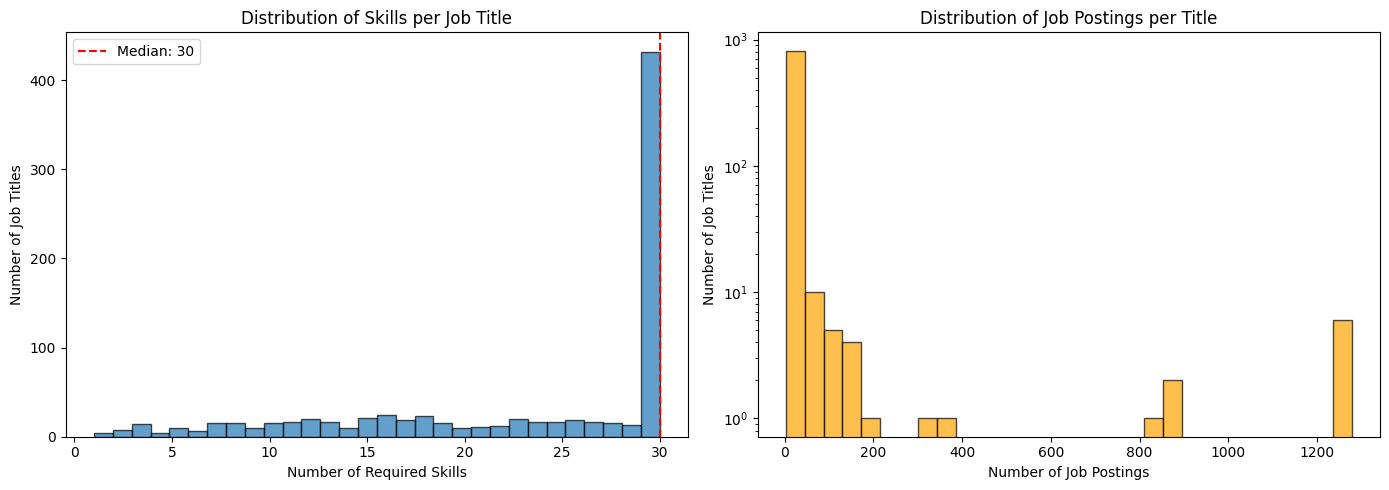

In [4]:
# Visualize: skills per title distribution
skills_per_title = [len(info['skills']) for info in title_skills.values()]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(skills_per_title, bins=30, edgecolor='black', alpha=0.7)
axes[0].set_title('Distribution of Skills per Job Title')
axes[0].set_xlabel('Number of Required Skills')
axes[0].set_ylabel('Number of Job Titles')
axes[0].axvline(np.median(skills_per_title), color='red', linestyle='--', label=f'Median: {np.median(skills_per_title):.0f}')
axes[0].legend()

jobs_per_title = [info['job_count'] for info in title_skills.values()]
axes[1].hist(jobs_per_title, bins=30, edgecolor='black', alpha=0.7, color='orange')
axes[1].set_title('Distribution of Job Postings per Title')
axes[1].set_xlabel('Number of Job Postings')
axes[1].set_ylabel('Number of Job Titles')
axes[1].set_yscale('log')

plt.tight_layout()
plt.savefig('figures/job_title_skill_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

## 6.3 Populate ChromaDB `job_titles` Collection

In [5]:
from ml.src.chromadb_manager import get_chroma_client, get_ephemeral_client, populate_job_title_collection

model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

# Connect to ChromaDB
try:
    chroma_client = get_chroma_client()
    chroma_client.heartbeat()
    print('Connected to ChromaDB Docker instance')
except Exception:
    print('ChromaDB Docker not available, using ephemeral client')
    chroma_client = get_ephemeral_client()

# Populate job title collection
job_collection, job_title_skills = populate_job_title_collection(
    chroma_client, model=model,
    job_skill_path=str(PROCESS_DIR / 'job_skill_mapping.parquet'),
)
print(f'\nJob title collection populated: {job_collection.count()} titles')

Loading weights: 100%|██████████| 103/103 [00:00<00:00, 1808.09it/s, Materializing param=pooler.dense.weight]                             
BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Connected to ChromaDB Docker instance


Batches: 100%|██████████| 14/14 [00:04<00:00,  3.35it/s]



Job title collection populated: 848 titles


In [6]:
# Verify: query some job titles
from ml.src.chromadb_manager import query_job_titles

test_queries = ['data scientist', 'software engineer', 'ML engineer', 'backend developer', 'product manager']

for query in test_queries:
    embedding = model.encode(query).tolist()
    results = query_job_titles(job_collection, embedding, n_results=5)
    print(f'\nQuery: "{query}"')
    for r in results:
        print(f'  → {r["job_title"]:40s} sim={r["similarity"]:.3f} ({r["job_count"]} jobs, {r["skill_count"]} skills)')


Query: "data scientist"
  → data scientist                           sim=1.000 (855 jobs, 3 skills)
  → data science engineer                    sim=0.851 (4 jobs, 30 skills)
  → data engineer                            sim=0.814 (41 jobs, 30 skills)
  → senior data scientist                    sim=0.809 (6 jobs, 30 skills)
  → data analyst                             sim=0.806 (43 jobs, 30 skills)

Query: "software engineer"
  → software engineer                        sim=1.000 (303 jobs, 30 skills)
  → software development engineer            sim=0.931 (10 jobs, 30 skills)
  → software engineer / programmer           sim=0.909 (3 jobs, 20 skills)
  → software application engineer            sim=0.908 (4 jobs, 30 skills)
  → software developer                       sim=0.873 (131 jobs, 30 skills)

Query: "ML engineer"
  → engineer                                 sim=0.729 (107 jobs, 30 skills)
  → manufacturing engineer                   sim=0.721 (32 jobs, 30 skills)
  → ml researc

## 6.4 Test Job Title Semantic Search

In [7]:
# Test semantic matching with variations
variations = [
    ('ML engineer', 'Should match machine learning engineer'),
    ('backend dev', 'Should match backend developer'),
    ('data analyst', 'Should match data analyst'),
    ('devops engineer', 'Should match devops or similar'),
    ('AI researcher', 'Should match AI/ML research roles'),
    ('frontend developer', 'Should match frontend/web developer'),
    ('cloud architect', 'Should match cloud/infrastructure roles'),
    ('fullstack developer', 'Should match full stack roles'),
    ('business analyst', 'Should match business/data analyst'),
    ('cybersecurity analyst', 'Should match security roles'),
]

print('Job Title Semantic Search Results:\n')
for query, expected in variations:
    embedding = model.encode(query).tolist()
    results = query_job_titles(job_collection, embedding, n_results=3)
    top_match = results[0] if results else None
    if top_match:
        status = '✓' if top_match['similarity'] >= 0.5 else '~'
        print(f'{status} "{query:25s}" → "{top_match["job_title"]:35s}" (sim={top_match["similarity"]:.3f})')
    else:
        print(f'✗ "{query}" → No match found')

Job Title Semantic Search Results:

✓ "ML engineer              " → "engineer                           " (sim=0.729)
✓ "backend dev              " → "backend developer                  " (sim=0.911)
✓ "data analyst             " → "data analyst                       " (sim=1.000)
✓ "devops engineer          " → "devops engineer                    " (sim=1.000)
✓ "AI researcher            " → "ai software engineer               " (sim=0.772)
✓ "frontend developer       " → "frontend developer                 " (sim=1.000)
✓ "cloud architect          " → "solution architect - cloud         " (sim=0.870)
✓ "fullstack developer      " → "fullstack developer                " (sim=1.000)
✓ "business analyst         " → "business analyst                   " (sim=1.000)
✓ "cybersecurity analyst    " → "cybersecurity analyst              " (sim=1.000)


## 6.5 Full Gap Analysis Pipeline

In [8]:
# Ensure skill_taxonomy collection exists (from notebook 05)
from ml.src.chromadb_manager import populate_skill_collection

try:
    chroma_client.get_collection('skill_taxonomy')
    print('skill_taxonomy collection already exists')
except Exception:
    print('Populating skill_taxonomy collection...')
    populate_skill_collection(
        chroma_client,
        taxonomy_path=str(PROCESS_DIR / 'skill_taxonomy_categorized.parquet'),
        embeddings_path=str(PROCESS_DIR / 'skill_embeddings.parquet'),
    )
    print('Done')

skill_taxonomy collection already exists


In [9]:
from ml.src.skill_gap_analyzer import SkillGapAnalyzer
from ml.src.skill_extractor import SkillExtractor

# Initialize both models
extractor = SkillExtractor(
    chroma_client=chroma_client, model=model,
    taxonomy_path=str(PROCESS_DIR / 'skill_taxonomy_categorized.parquet'),
)

analyzer = SkillGapAnalyzer(
    chroma_client=chroma_client, model=model,
    job_skill_path=str(PROCESS_DIR / 'job_skill_mapping.parquet'),
    taxonomy_path=str(PROCESS_DIR / 'skill_taxonomy_categorized.parquet'),
    embeddings_path=str(PROCESS_DIR / 'skill_embeddings.parquet'),
)

print('Models initialized successfully')

Models initialized successfully


In [10]:
# Scenario 1: Junior Developer → Data Scientist (large gap expected)
user_skills_1 = extractor.extract_from_skill_list('Python, SQL, Excel, Statistics, Git')
result_1 = analyzer.analyze(user_skills_1, 'Data Scientist')

print('SCENARIO 1: Junior Developer → Data Scientist')
print(f'Matched job title: "{result_1.job_title_matched}" (confidence: {result_1.job_title_confidence:.3f})')
print(f'Readiness score: {result_1.overall_readiness_score:.1%}')
print(f'\nMatched skills ({len(result_1.matched_skills)}):')
for m in result_1.matched_skills:
    print(f'  ✓ {m.user_skill:25s} → {m.required_skill:25s} [{m.category}] sim={m.similarity:.3f}')
print(f'\nMissing skills ({len(result_1.missing_skills)}):')
for m in result_1.missing_skills[:10]:
    print(f'  ✗ {m.skill_name:25s} [{m.category:20s}] freq={m.frequency:.2f}')
print(f'\nCategory breakdown:')
for cat, score in result_1.category_breakdown.items():
    bar = '█' * int(score.coverage_pct * 20) + '░' * (20 - int(score.coverage_pct * 20))
    print(f'  {cat:25s} {bar} {score.coverage_pct:.0%} ({score.user_has}/{score.total_required})')

SCENARIO 1: Junior Developer → Data Scientist
Matched job title: "data scientist" (confidence: 1.000)
Readiness score: 33.3%

Matched skills (1):
  ✓ python                    → python                    [tech_skills] sim=1.000

Missing skills (2):
  ✗ tensorflow                [tech_skills         ] freq=0.67
  ✗ pytorch                   [tech_skills         ] freq=0.61

Category breakdown:
  tech_skills               ██████░░░░░░░░░░░░░░ 33% (1/3)


In [11]:
# Scenario 2: Data Analyst → Data Scientist (small gap expected)
user_skills_2 = extractor.extract_from_skill_list(
    'Python, SQL, Statistics, Data Visualization, Tableau, Machine Learning, Pandas, Excel, PowerBI'
)
result_2 = analyzer.analyze(user_skills_2, 'Data Scientist')

print('SCENARIO 2: Data Analyst → Data Scientist')
print(f'Matched job title: "{result_2.job_title_matched}" (confidence: {result_2.job_title_confidence:.3f})')
print(f'Readiness score: {result_2.overall_readiness_score:.1%}')
print(f'\nMatched skills ({len(result_2.matched_skills)}):')
for m in result_2.matched_skills:
    print(f'  ✓ {m.user_skill:25s} → {m.required_skill:25s} sim={m.similarity:.3f}')
print(f'\nMissing skills ({len(result_2.missing_skills)}):')
for m in result_2.missing_skills[:10]:
    print(f'  ✗ {m.skill_name:25s} [{m.category:20s}] freq={m.frequency:.2f}')

SCENARIO 2: Data Analyst → Data Scientist
Matched job title: "data scientist" (confidence: 1.000)
Readiness score: 33.3%

Matched skills (1):
  ✓ python                    → python                    sim=1.000

Missing skills (2):
  ✗ tensorflow                [tech_skills         ] freq=0.67
  ✗ pytorch                   [tech_skills         ] freq=0.61


In [12]:
# Scenario 3: Non-tech → Frontend Developer (career switch)
user_skills_3 = extractor.extract_from_skill_list(
    'Communication, Project Management, Microsoft Office, Teamwork, Problem Solving'
)
result_3 = analyzer.analyze(user_skills_3, 'Frontend Developer')

print('SCENARIO 3: Non-tech → Frontend Developer (career switch)')
print(f'Matched job title: "{result_3.job_title_matched}" (confidence: {result_3.job_title_confidence:.3f})')
print(f'Readiness score: {result_3.overall_readiness_score:.1%}')
print(f'\nMatched skills ({len(result_3.matched_skills)}):')
for m in result_3.matched_skills:
    print(f'  ✓ {m.user_skill:25s} → {m.required_skill:25s} sim={m.similarity:.3f}')
print(f'\nMissing skills ({len(result_3.missing_skills)}):')
for m in result_3.missing_skills[:15]:
    print(f'  ✗ {m.skill_name:25s} [{m.category:20s}] freq={m.frequency:.2f}')
print(f'\nCategory breakdown:')
for cat, score in result_3.category_breakdown.items():
    bar = '█' * int(score.coverage_pct * 20) + '░' * (20 - int(score.coverage_pct * 20))
    print(f'  {cat:25s} {bar} {score.coverage_pct:.0%} ({score.user_has}/{score.total_required})')

SCENARIO 3: Non-tech → Frontend Developer (career switch)
Matched job title: "frontend developer" (confidence: 1.000)
Readiness score: 10.0%

Matched skills (3):
  ✓ communication             → communication             sim=1.000
  ✓ teamwork                  → teamwork                  sim=1.000
  ✓ project management        → project management        sim=1.000

Missing skills (27):
  ✗ javascript                [tech_skills         ] freq=0.84
  ✗ react                     [tech_skills         ] freq=0.63
  ✗ git                       [tech_skills         ] freq=0.53
  ✗ typescript                [tech_skills         ] freq=0.42
  ✗ css                       [tech_skills         ] freq=0.42
  ✗ web applications          [tech_skills         ] freq=0.37
  ✗ computer science          [tech_skills         ] freq=0.37
  ✗ vue                       [tech_skills         ] freq=0.32
  ✗ version control           [tech_skills         ] freq=0.32
  ✗ html                      [tech_skills   

## 6.6 Visualization: Radar Chart & Gap Bar Chart

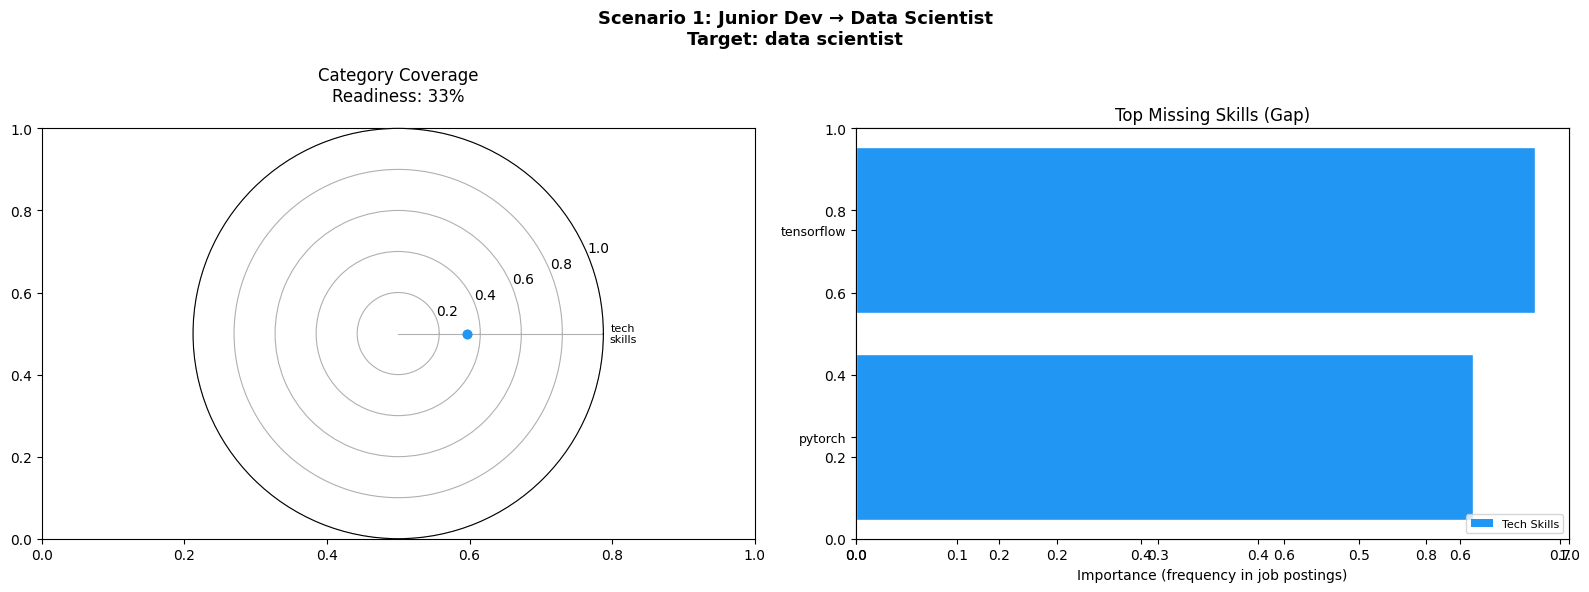

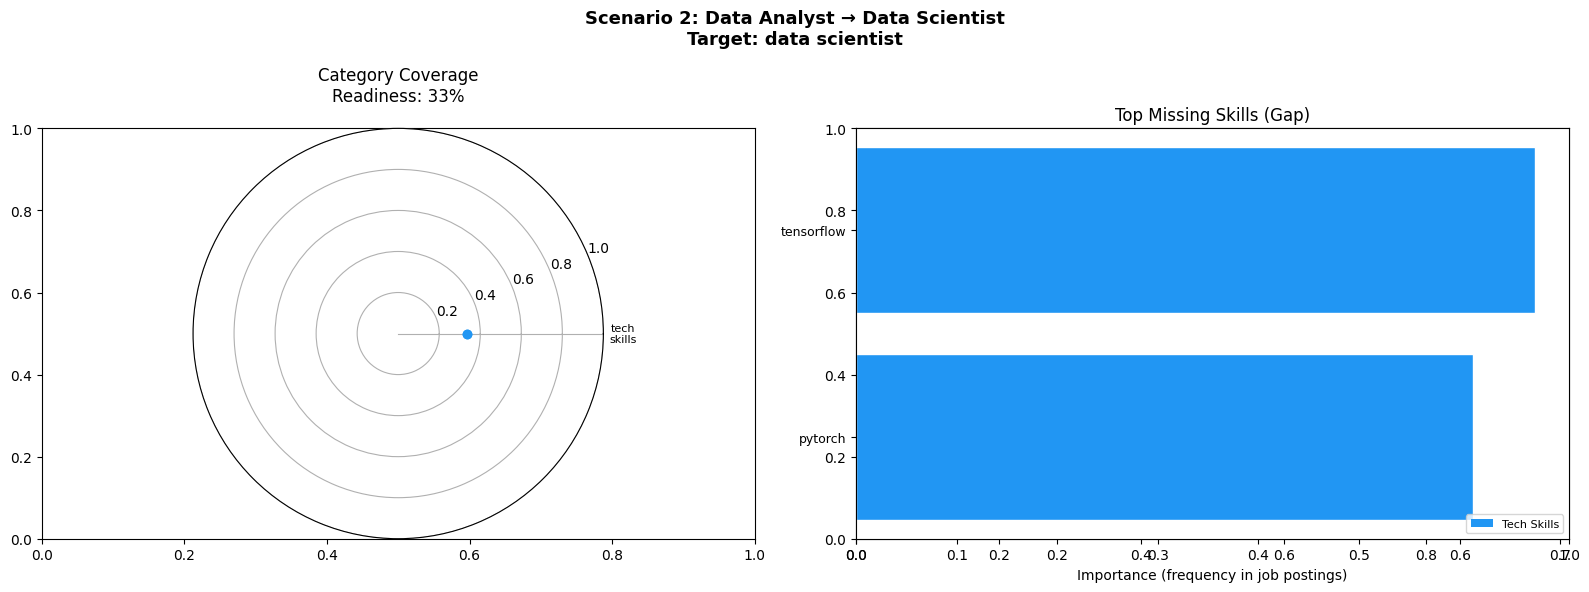

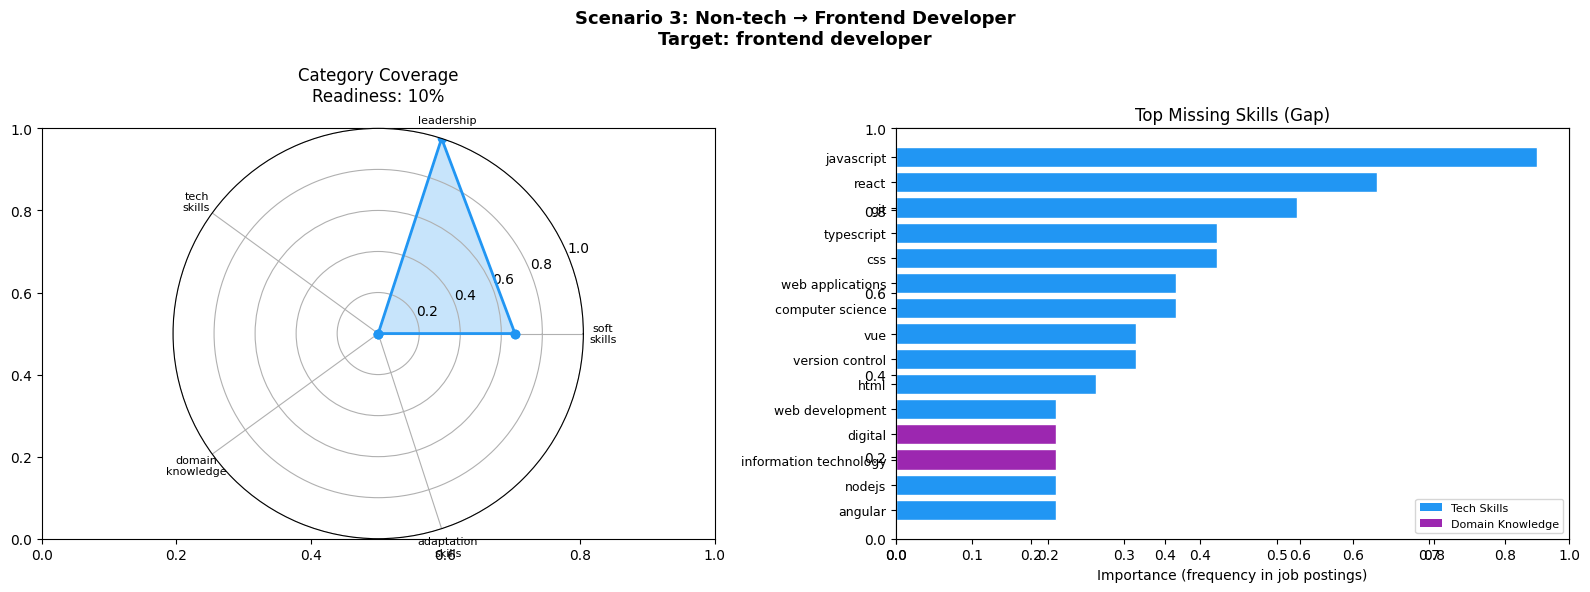

In [13]:
def plot_gap_analysis(result, title='Skill Gap Analysis'):
    """Visualize gap analysis with radar chart and missing skills bar chart."""
    fig, axes = plt.subplots(1, 2, figsize=(16, 6),
                             subplot_kw={'polar': True} if False else {})
    
    # --- Radar Chart (Category Coverage) ---
    ax1 = fig.add_subplot(121, polar=True)
    categories = list(result.category_breakdown.keys())
    if not categories:
        ax1.text(0.5, 0.5, 'No category data', transform=ax1.transAxes, ha='center')
    else:
        values = [result.category_breakdown[c].coverage_pct for c in categories]
        # Short labels for readability
        short_labels = [c.replace('_', '\n') for c in categories]
        
        N = len(categories)
        angles = [n / float(N) * 2 * np.pi for n in range(N)]
        values += values[:1]
        angles += angles[:1]
        
        ax1.plot(angles, values, 'o-', linewidth=2, color='#2196F3')
        ax1.fill(angles, values, alpha=0.25, color='#2196F3')
        ax1.set_xticks(angles[:-1])
        ax1.set_xticklabels(short_labels, size=8)
        ax1.set_ylim(0, 1)
        ax1.set_title(f'Category Coverage\nReadiness: {result.overall_readiness_score:.0%}', pad=20)
    
    # --- Missing Skills Bar Chart ---
    axes[1].clear() if hasattr(axes, '__len__') else None
    ax2 = fig.add_subplot(122)
    missing = result.missing_skills[:15]  # top 15
    if missing:
        skill_names = [m.skill_name for m in missing]
        frequencies = [m.frequency for m in missing]
        colors_map = {
            'tech_skills': '#2196F3', 'soft_skills': '#4CAF50',
            'leadership': '#FF9800', 'domain_knowledge': '#9C27B0',
            'adaptation_skills': '#F44336'
        }
        bar_colors = [colors_map.get(m.category, '#999') for m in missing]
        
        y_pos = range(len(skill_names))
        ax2.barh(y_pos, frequencies, color=bar_colors, edgecolor='white')
        ax2.set_yticks(y_pos)
        ax2.set_yticklabels(skill_names, fontsize=9)
        ax2.invert_yaxis()
        ax2.set_xlabel('Importance (frequency in job postings)')
        ax2.set_title('Top Missing Skills (Gap)')
        
        # Add legend
        from matplotlib.patches import Patch
        legend_elements = [Patch(facecolor=c, label=l.replace('_', ' ').title())
                          for l, c in colors_map.items()
                          if l in {m.category for m in missing}]
        ax2.legend(handles=legend_elements, loc='lower right', fontsize=8)
    else:
        ax2.text(0.5, 0.5, 'No missing skills!', transform=ax2.transAxes,
                ha='center', va='center', fontsize=14, color='green')
    
    fig.suptitle(f'{title}\nTarget: {result.job_title_matched}', fontsize=13, fontweight='bold')
    plt.tight_layout()
    return fig


# Plot all 3 scenarios
for i, (result, label) in enumerate([
    (result_1, 'Scenario 1: Junior Dev → Data Scientist'),
    (result_2, 'Scenario 2: Data Analyst → Data Scientist'),
    (result_3, 'Scenario 3: Non-tech → Frontend Developer'),
], 1):
    fig = plot_gap_analysis(result, label)
    fig.savefig(f'figures/gap_analysis_scenario_{i}.png', dpi=150, bbox_inches='tight')
    plt.show()

## 6.7 Edge Cases

In [14]:
# Edge case 1: User has no skills
print('EDGE CASE 1: No user skills')
result_empty = analyzer.analyze([], 'Data Scientist')
print(f'  Readiness: {result_empty.overall_readiness_score:.1%}')
print(f'  Matched: {len(result_empty.matched_skills)}, Missing: {len(result_empty.missing_skills)}')

# Edge case 2: Unknown/rare job title
print('\nEDGE CASE 2: Unknown job title')
result_unknown = analyzer.analyze(
    extractor.extract_from_skill_list('Python, SQL'),
    'Quantum Blockchain AI Specialist'
)
print(f'  Matched title: "{result_unknown.job_title_matched}"')
print(f'  Confidence: {result_unknown.job_title_confidence:.3f}')
print(f'  Readiness: {result_unknown.overall_readiness_score:.1%}')

# Edge case 3: User has all required skills
print('\nEDGE CASE 3: User has many overlapping skills')
# Get the top skills for a common title and use them as user skills
if 'data scientist' in job_title_skills:
    top_skills_ds = [s['skill'] for s in job_title_skills['data scientist']['skills'][:15]]
    result_full = analyzer.analyze(top_skills_ds, 'Data Scientist')
    print(f'  User has {len(top_skills_ds)} skills matching top required skills')
    print(f'  Readiness: {result_full.overall_readiness_score:.1%}')
    print(f'  Matched: {len(result_full.matched_skills)}, Missing: {len(result_full.missing_skills)}')
else:
    print('  (data scientist not found in aggregated titles)')

EDGE CASE 1: No user skills
  Readiness: 0.0%
  Matched: 0, Missing: 3

EDGE CASE 2: Unknown job title
  Matched title: "quantum software developer"
  Confidence: 0.702
  Readiness: 0.0%

EDGE CASE 3: User has many overlapping skills
  User has 3 skills matching top required skills
  Readiness: 100.0%
  Matched: 3, Missing: 0


In [15]:
# End-to-end test: Raw CV text → SkillExtractor → SkillGapAnalyzer → Result
print('END-TO-END TEST:')
print('='*60)

cv_text = """I am a software engineer with 3 years of experience building web applications.
Proficient in Python, JavaScript, React, and Node.js. I have worked with PostgreSQL
and MongoDB databases. Experience with Docker and basic AWS deployments.
Strong team player with good communication skills."""

print(f'Input CV text:\n{cv_text}\n')

# Step 1: Extract skills
extracted = extractor.extract_from_text(cv_text)
print(f'Step 1 - Extracted {len(extracted)} skills:')
for s in extracted:
    print(f'  {s.skill_name:25s} [{s.category}] conf={s.confidence:.3f}')

# Step 2: Analyze gap
target_job = 'Senior Data Engineer'
print(f'\nStep 2 - Gap analysis for target: "{target_job}"')
gap_result = analyzer.analyze(extracted, target_job)

print(f'  Matched title: "{gap_result.job_title_matched}" (conf: {gap_result.job_title_confidence:.3f})')
print(f'  Readiness: {gap_result.overall_readiness_score:.1%}')
print(f'  Matched: {len(gap_result.matched_skills)} skills')
print(f'  Missing: {len(gap_result.missing_skills)} skills')

# Step 3: Convert to JSON (for API response)
result_json = gap_result.to_dict()
print(f'\nStep 3 - JSON output keys: {list(result_json.keys())}')
print(f'JSON serializable: {json.dumps(result_json) is not None}')

END-TO-END TEST:
Input CV text:
I am a software engineer with 3 years of experience building web applications.
Proficient in Python, JavaScript, React, and Node.js. I have worked with PostgreSQL
and MongoDB databases. Experience with Docker and basic AWS deployments.
Strong team player with good communication skills.

Step 1 - Extracted 10 skills:
  web applications          [tech_skills] conf=1.000
  python                    [tech_skills] conf=1.000
  javascript                [tech_skills] conf=1.000
  react                     [tech_skills] conf=1.000
  postgresql                [tech_skills] conf=1.000
  mongodb                   [tech_skills] conf=1.000
  databases                 [tech_skills] conf=1.000
  docker                    [tech_skills] conf=1.000
  amazon web services       [tech_skills] conf=1.000
  communication             [soft_skills] conf=1.000

Step 2 - Gap analysis for target: "Senior Data Engineer"
  Matched title: "senior data engineer" (conf: 1.000)
  Readin

In [16]:
print('\n✅ Notebook 06 complete.')
print('Artifacts produced:')
print('  - ChromaDB job_titles collection (populated)')
print('  - SkillGapAnalyzer class validated in ml/src/skill_gap_analyzer.py')
print('  - Gap analysis visualizations in figures/')
print('\nBoth models are ready for FastAPI backend integration.')


✅ Notebook 06 complete.
Artifacts produced:
  - ChromaDB job_titles collection (populated)
  - SkillGapAnalyzer class validated in ml/src/skill_gap_analyzer.py
  - Gap analysis visualizations in figures/

Both models are ready for FastAPI backend integration.
